In [76]:
# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px

# modeling
import statsmodels.api as sm

pd.set_option('display.max_columns', None)

In [17]:
# local or gdrive
path_source = 'gdrive'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data/joined_data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data/joined_data'
  #env_path = '/content/gdrive/MyDrive/.env'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
# load full dataset
df = pd.read_parquet(os.path.join(data_path, 'joined_filtered_data.parquet'))

# Data Clean

Clean the dates:
- For schools that don't have open/close dates, just assume the school was always open by setting early/late dates. 
- Then use the school open/closed dates and filter out schools that were closed. 

In [19]:
# func to fill in the missing school closed/open dates
def date_fill(x, start_or_end='start'):
  if x == 'No Data' and start_or_end == 'start':
    output = '1/1/1990'
  elif x == 'No Data' and start_or_end == 'end':
    output = '1/1/2025'
  else:
    output = x 

  try:
    output = datetime.strptime(output, '%m/%d/%Y')
  except:
    return None

  return output


# for all missing dates, just assume the school was always open. 
df['school_open_date'] = df['school_open_date'].progress_map(lambda x: date_fill(x, 'start'))
df['school_closed_date'] = df['school_closed_date'].progress_map(lambda x: date_fill(x, 'end'))

# convert to datetime format
# df['school_open_date'] = df['school_open_date'].progress_map(lambda x: datetime.strptime(x, '%m/%d/%Y'))
# df['school_closed_date'] = df['school_closed_date'].progress_map(lambda x: datetime.strptime(x, '%m/%d/%Y'))

# do the same for the year_month field. But use this function in case there are NAs
def strptime2(x):
  try: 
    return datetime.strptime(x, '%Y-%m')
  except:
    return None

df['year_month_date'] = df['year_month'].progress_map(strptime2)


# create logic to filter out closed schools
def is_school_open(start, end, current):
  if (start <= current) and (end >= current):
    return 1 
  else: 
    return 0 

df['is_school_open'] = df\
  .progress_apply(lambda df: is_school_open(
      df['school_open_date'], 
      df['school_closed_date'], 
      df['year_month_date']), 
    axis=1)

  0%|          | 0/2983111 [00:00<?, ?it/s]

  0%|          | 0/2983111 [00:00<?, ?it/s]

  0%|          | 0/2983111 [00:00<?, ?it/s]

  0%|          | 0/2983111 [00:00<?, ?it/s]

In [21]:
# check counts
df['is_school_open'].value_counts()

1    2471552
0     511559
Name: is_school_open, dtype: int64

In [23]:
# filter out schools that aren't open
df = df[df['is_school_open'] != 0]

In [29]:
df.head(3)

,year,cdscode,school_county,school_zip,school_region_name,school_open_date,school_closed_date,school_lat,school_lon,school_wspd,school_elevation_m,year_month,total_population,total_population_male,total_population_female,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,pop_under19_male,pop_under19_female,total_pop_under19,pm25,point_source_lat,point_source_lon,ps_elevation_m,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wind_lat,ps_wind_lon,ps_wspd_merge,school_wdir_wrt_0N,ps_wdir_wrt_0N,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,year_month_date,is_school_open
0,2010.0,20102070109728,Madera,93610,Northern San Joaquin Valley,2005-08-16,2014-06-30,37.115210,-120.26603,1.531352,70.84,2010-04,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.0,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,1873.525780181077,-55.29643968357893,NaN,NaN,1.531352,102.528057,102.528057,157.824497,157.824497,1.531352,157.824497,0.073968,2010-04-01,1
1,2010.0,20102072030187,Madera,93610,Northern San Joaquin Valley,2001-01-22,2014-06-30,37.115210,-120.26603,1.531352,70.84,2010-04,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.0,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,1873.525780181077,-55.29643968357893,NaN,NaN,1.531352,102.528057,102.528057,157.824497,157.824497,1.531352,157.824497,0.073968,2010-04-01,1
2,2010.0,20651930000000,Madera,93610,Northern San Joaquin Valley,1990-01-01,2025-01-01,37.122449,-120.26487,1.531352,72.77,2010-04,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.0,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,2358.38241919395,-37.54028477906731,NaN,NaN,1.531352,102.528057,102.528057,140.068342,140.068342,1.531352,140.068342,0.233189,2010-04-01,1


In [40]:
# fix some datatypes
num_vars = ['angle_to_school', 'ps_elevation_m', 'pm25', 'point_source_pm25_tpy', 
            'dist_school_to_ps_m', 'angle_to_school']

for var in num_vars:
  df[var] = df[var].astype(float)

In [65]:
# filter out na pm2.5 values
df = df[~df['pm25'].isna()]

# just mean impute missing populations
df['pop_under19_male'] = df['pop_under19_male'].fillna(df['pop_under19_male'].mean())
df['pop_under19_female'] = df['pop_under19_female'].fillna(df['pop_under19_female'].mean())

# Aggregate data to zip/month level

In [66]:
# maybe not all of these should use 'mean', but doing it this way for now. 
mean_vars = ['school_wspd', 'school_elevation_m', 'ps_elevation_m', 'pop_under19_male', 
             'pop_under19_female', 'pm25', 'point_source_pm25_tpy', 'dist_school_to_ps_m', 
             'angle_to_school', 'ps_wspd_merge', 'school_wdir_wrt_0N', 'ps_wdir_wrt_0N', 
             'school_wind_alignment', 'ps_wind_alignment', 'avg_wind_speed', 
             'avg_wind_alignment', 'avg_wind_alignment_cosine']
mean_dict = {var:(var, 'mean') for var in mean_vars}

df_grp = df\
  .groupby(['year_month_date', 'school_county', 'school_region_name', 'school_zip'])\
  .agg(**mean_dict)\
  .reset_index()

df_grp.head(3)

,year_month_date,school_county,school_region_name,school_zip,school_wspd,school_elevation_m,ps_elevation_m,pop_under19_male,pop_under19_female,pm25,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0N,ps_wdir_wrt_0N,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine
0,2000-01-01,Alameda,San Francisco Bay Area,94501,1.006650,6.142667,3.793333,6855.0,6497.0,14.600000,5.258067,1717.410608,-33.389362,0.628877,63.227197,68.462249,140.776564,137.445167,0.817763,139.110866,0.337179
1,2000-01-01,Alameda,San Francisco Bay Area,94502,1.006650,4.655000,4.210000,1859.0,1845.0,14.880000,9.449277,3018.878458,-139.679287,0.491505,63.227197,70.365905,157.093516,149.954808,0.749077,153.524162,0.113934
2,2000-01-01,Alameda,San Francisco Bay Area,94514,0.720902,27.460000,315.130000,1487.0,1294.0,20.241379,153.132229,7501.370079,57.048970,0.724224,57.298135,64.797385,0.249165,7.748415,0.722563,3.998790,1.997562


hmmm strangly some values in the same zip code, will have diff county and regions...

this example is simi valley

In [61]:
df_grp[(df_grp.year_month_date == datetime.strptime('2014-07-01', '%Y-%m-%d')) & (df_grp.school_zip == '93065')]

,year_month_date,school_county,school_region_name,school_zip,school_wspd,school_elevation_m,ps_elevation_m,pop_under19_male,pop_under19_female,pm25,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0N,ps_wdir_wrt_0N,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine
246248,2014-07-01,Fresno,Southern San Joaquin Valley,93065,1.509139,217.770000,290.71,9052.446,9445.244,9.053333,9.916024,1754.362438,163.471549,1.509139,47.089317,47.089317,116.382232,116.382232,1.509139,116.382232,0.555643
246349,2014-07-01,Kern,Southern San Joaquin Valley,93065,1.509139,217.770000,290.71,9052.446,9445.244,9.053333,9.916024,1754.362438,163.471549,1.509139,47.089317,47.089317,116.382232,116.382232,1.509139,116.382232,0.555643
246392,2014-07-01,Kings,Southern San Joaquin Valley,93065,1.509139,217.770000,290.71,9052.446,9445.244,9.053333,9.916024,1754.362438,163.471549,1.509139,47.089317,47.089317,116.382232,116.382232,1.509139,116.382232,0.555643
246657,2014-07-01,Los Angeles,Los Angeles County,93065,1.509139,217.770000,290.71,9052.446,9445.244,9.053333,9.916024,1754.362438,163.471549,1.509139,47.089317,47.089317,116.382232,116.382232,1.509139,116.382232,0.555643
247155,2014-07-01,San Diego,San Diego - Imperial,93065,1.509139,217.770000,290.71,9052.446,9445.244,9.053333,9.916024,1754.362438,163.471549,1.509139,47.089317,47.089317,116.382232,116.382232,1.509139,116.382232,0.555643
247179,2014-07-01,San Joaquin,Northern San Joaquin Valley,93065,1.509139,217.770000,290.71,9052.446,9445.244,9.053333,9.916024,1754.362438,163.471549,1.509139,47.089317,47.089317,116.382232,116.382232,1.509139,116.382232,0.555643
247224,2014-07-01,San Mateo,San Francisco Bay Area,93065,1.509139,217.770000,290.71,9052.446,9445.244,9.053333,9.916024,1754.362438,163.471549,1.509139,47.089317,47.089317,116.382232,116.382232,1.509139,116.382232,0.555643
247384,2014-07-01,Sonoma,North Coast,93065,1.509139,217.770000,290.71,9052.446,9445.244,9.053333,9.916024,1754.362438,163.471549,1.509139,47.089317,47.089317,116.382232,116.382232,1.509139,116.382232,0.555643
247426,2014-07-01,Sutter,Superior California,93065,1.509139,217.770000,290.71,9052.446,9445.244,9.053333,9.916024,1754.362438,163.471549,1.509139,47.089317,47.089317,116.382232,116.382232,1.509139,116.382232,0.555643
247517,2014-07-01,Ventura,Central Coast,93065,1.509139,267.094762,290.71,9052.446,9445.244,9.053333,9.916024,5040.601195,112.703179,1.509139,47.089317,47.089317,82.756719,82.756719,1.509139,82.756719,1.123762


In [68]:
# check NA
df_grp.isna().sum()

year_month_date              0
school_county                0
school_region_name           0
school_zip                   0
school_wspd                  0
school_elevation_m           0
ps_elevation_m               0
pop_under19_male             0
pop_under19_female           0
pm25                         0
point_source_pm25_tpy        0
dist_school_to_ps_m          0
angle_to_school              0
ps_wspd_merge                0
school_wdir_wrt_0N           0
ps_wdir_wrt_0N               0
school_wind_alignment        0
ps_wind_alignment            0
avg_wind_speed               0
avg_wind_alignment           0
avg_wind_alignment_cosine    0
dtype: int64

# Modeling

### A very baseline linear model

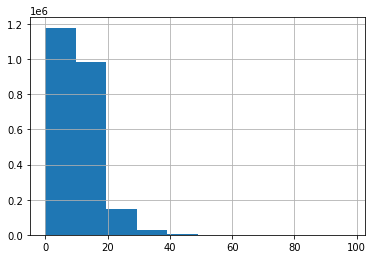

In [69]:
df.pm25.hist()

In [72]:
x_vars = ['school_wspd', 'school_elevation_m', 'ps_elevation_m', 'pop_under19_male', 
          'pop_under19_female', 'dist_school_to_ps_m', 'ps_wspd_merge', 
          'school_wdir_wrt_0N', 'ps_wdir_wrt_0N', 'school_wind_alignment', 
          'ps_wind_alignment', 'avg_wind_speed', 'avg_wind_alignment']

X = df_grp[x_vars]
y = df_grp['pm25']

In [75]:
# add constant
X = sm.add_constant(X)

# fit
est = sm.OLS(y, X).fit()

# see summary
print(est.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     6903.
Date:                Tue, 04 Oct 2022   Prob (F-statistic):               0.00
Time:                        05:22:12   Log-Likelihood:            -1.0023e+06
No. Observations:              323362   AIC:                         2.005e+06
Df Residuals:                  323350   BIC:                         2.005e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.94